# Control de un tanque cónico regulando el caudal de entrada

![Esquema del tanque cónico](tanque_conico.png)

datos:
- a: sección de la tubería de salida
- g: aceleración de la gravedad

In [2]:
import sympy as sp
import numpy as np
import control as ctrl
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

Primero obtenemos el modelo no lineal expresado como una ecuación diferencial de primer orden del tipo:

$\frac{dh}{dt} = f(h,qe,t)$

In [3]:
h, dhdt, qe, pi, a, g = sp.symbols('h,dhdt,qe,pi,a,g',real=True)

V = 1/3 * pi * h**3
print("Formula del volumen del cono")
display(V)

# Balance de masas
dVdt_req = qe - a*sp.sqrt(2*g*h)
dVdt_leq = sp.diff(V,h) * dhdt 
balance_masas = sp.Eq(dVdt_leq, dVdt_req)
print("Balance de masas:")
display(balance_masas)

f = sp.solve(balance_masas, dhdt)[0]
print("Modelo no lineal:")
display(f)

Formula del volumen del cono


0.333333333333333*h**3*pi

Balance de masas:


Eq(1.0*dhdt*h**2*pi, -sqrt(2)*a*sqrt(g*h) + qe)

Modelo no lineal:


(-1.4142135623731*a*sqrt(g*h) + qe)/(h**2*pi)

Luego obtenemos el modelo linealizado observando que $f$ depende de la altura y el caudal de entrada

$\frac{d(h_0+\Delta h)}{dt} = f(h_0,qe_0) + \frac{df}{dh}|_{h_0,qe_0} (h-h_0) + \frac{df}{dqe}|_{h_0,qe_0} (q-qe_0) $

Como en el punto de equilibrio las derivadas se anulan
$f(h_0,qe_0)=0$

se puede despejar el punto de equilibrio y además se simplifica la ec. de estado:

$\frac{d(\Delta h)}{dt} = \frac{df}{dh}|_{h_0,qe_0} \Delta h + \frac{df}{dqe}|_{h_0,qe_0} \Delta qe $



In [4]:
h0, qe0 = sp.symbols('h0,qe0',real=True)
dh, dqe = sp.symbols('dh,dqe',real=True)

# Evaluar f en el punto (h0, qe0)
f0 = f.subs({h: h0, qe: qe0})
qe0 = sp.solve(sp.Eq(f0, 0), qe0)[0]
print("Caudal de entrada para el punto de equilibrio dado por h0")
display(qe0)

# Derivadas parciales en el punto
df_dh = sp.diff(f, h).subs({h: h0, qe: qe0})
df_dqe = sp.diff(f, qe).subs({h: h0, qe: qe0})

# Ecuación linealizada
dhdt_lin = df_dh*(dh) + df_dqe*(dqe)


print("Ecuación linealizada:", dhdt_lin)
display(dhdt_lin)

Caudal de entrada para el punto de equilibrio dado por h0


1.4142135623731*a*sqrt(g*h0)

Ecuación linealizada: -0.707106781186557*a*dh*sqrt(g*h0)/(h0**3*pi) + dqe/(h0**2*pi)


-0.707106781186557*a*dh*sqrt(g*h0)/(h0**3*pi) + dqe/(h0**2*pi)

El modelo linealizado es de la forma:

$$G(s) = \frac{\beta}{s+\alpha} = \frac{K}{\tau s +1}$$

In [5]:
# Obtengo los parámetros del sistema lineal

alpha = -sp.diff(dhdt_lin,dh) 
display(alpha)

beta = sp.diff(dhdt_lin,dqe) 
display(beta)

0.707106781186557*a*sqrt(g*h0)/(h0**3*pi)

1/(h0**2*pi)

## Simulación del sistema no lineal vs linealizado

- Punto de trabajo h_0=1m
- a = 0.1m


In [6]:
a_val = 0.1
g_val = 9.81
h0_val = 1
qe0_val = qe0.subs({h0:h0_val,a:a_val,g:g_val})
print(f"Estado estacionario. h0={h0_val}  qe0={qe0_val}")

f_subs = f.subs({h0:1,a:a_val,g:g_val,pi:np.pi}).evalf()
print("Función no lineal:")
display(f_subs)

# Función numérica dhdt(qe, a, g, h, A)
dhdt_lambda = sp.lambdify((qe, h), f_subs, 'numpy')
print(f"Pruebo que esté bien calculado verificando el valor de la función en estado estacionario\n f(qe0,h0)={dhdt_lambda(qe0_val,h0_val)}")

# Obtengo el modelo linealizado
alpha_subs = np.double(alpha.subs({h0:1,a:a_val,g:g_val,pi:np.pi}).evalf())
beta_subs = np.double(beta.subs({h0:1,a:a_val,g:g_val,pi:np.pi}).evalf())
G = ctrl.TransferFunction([beta_subs],[1,alpha_subs])
print("Modelo linealizado")
display(G)


Estado estacionario. h0=1  qe0=0.442944691807004
Función no lineal:


0.318309886183791*(-0.442944691807002*h**0.5 + qe)/h**2

Pruebo que esté bien calculado verificando el valor de la función en estado estacionario
 f(qe0,h0)=4.94752950449881E-16
Modelo linealizado


TransferFunction(array([0.31830989]), array([1.        , 0.07049684]))

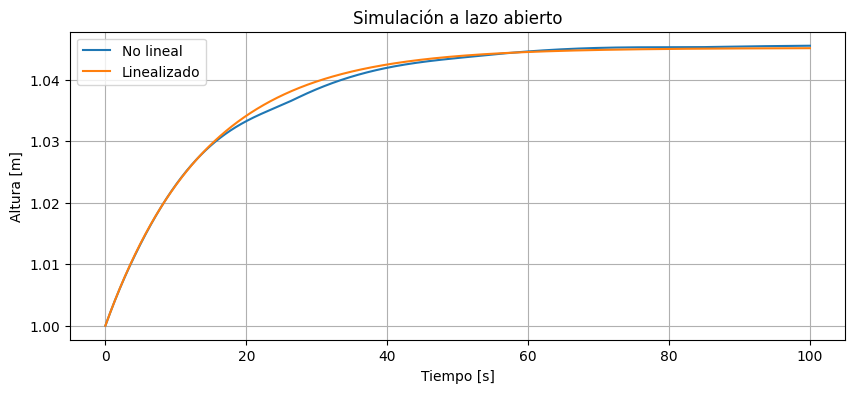

In [7]:

# Podemos ver qué pasa con las respuestas cuando cambiamos estos valores
delta_step = 0.01
hini = h0_val*1


# En este punto tengo el modelo no lineal. Hora de simular la respuesta al escalón
def modelo(t, h):
    if t<0.0:
        q=qe0_val
    else:
        q=qe0_val+delta_step
    return [dhdt_lambda(q,h)]

t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 5000)
sol = solve_ivp(modelo, t_span, [hini], t_eval=t_eval, method='RK45')

# Y el lineal
t,y = ctrl.step_response(G,T=t_eval)

plt.figure(figsize=(10,4))
plt.plot(sol.t, sol.y[0], label='No lineal')
plt.plot(t, y*delta_step+hini, label='Linealizado')
#plt.axhline(h_ref, color='r', linestyle='--', label='Referencia $h_{ref}$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Altura [m]')
plt.title('Simulación a lazo abierto')
plt.grid(True)
plt.legend()
plt.show()

# Inclusión del control
Tenemos el sistema G con un polo en -alpha, y queremos una respuesta con una dinámica dada por tau

Ganancia calculada: 2.9201203076862887


TransferFunction(array([0.92950316]), array([1., 1.]))

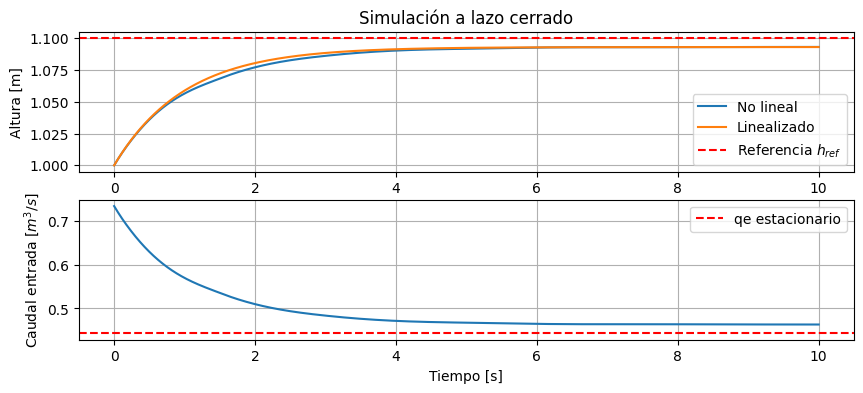

In [64]:
# Podemos probar distintas respuestas variando estos parámetros
hini = 1
tau_deseado = 1
h_ref = 1.1
q_max = 1
t_span = (0, 10*tau_deseado)

# Calculo el controlador
Kp = ctrl.acker(-alpha_subs,beta_subs,[-1/tau_deseado]).flatten()[0]
print(f"Ganancia calculada: {Kp}")

Gcl = ctrl.feedback(Kp*G,1)
display(Gcl)

def lc(t, h):
    q = float(qe0_val + Kp * (h_ref-h[0]))
    if q<0:
        q=0
    elif q>q_max:
        q=q_max
    return [dhdt_lambda(q,h[0])]

t_eval = np.linspace(t_span[0], t_span[1], 5000)
sol = solve_ivp(lc, t_span, [hini], t_eval=t_eval, method='RK45')

# Calculo la actuación que se utilizó en la simulación para graficar
q_t = qe0_val + Kp * (h_ref - sol.y[0])


# Y el lineal
t,y = ctrl.step_response(Gcl,T=t_eval)

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(sol.t, sol.y[0], label='No lineal')
plt.plot(t, y*(h_ref-hini)+hini, label='Linealizado')
plt.axhline(h_ref,color='r', linestyle='--', label='Referencia $h_{ref}$')
plt.ylabel('Altura [m]')
plt.title('Simulación a lazo cerrado')
plt.grid(True)
plt.legend()
plt.subplot(2,1,2)
plt.plot(sol.t,q_t)
plt.axhline(qe0_val,color='r', linestyle='--', label='qe estacionario')
plt.ylabel('Caudal entrada $[m^3/s]$')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid(True)

plt.show()

# ¿Cómo incluimos la parte integral ?

Ya vimos que no llegamos al setpoint. Falta integral.

Si queremos que el sistema de lazo cerrado se comporte con la dinámica

$$ T=\frac{1}{\gamma \tau s +1}$$

Entonces se tiene que cumplir

$$ T = \frac{CG}{1+CG} \\
 CG = T(1+CG) = T + TCG \\
 CG - TCG = T \\
 CG(1-T) = T \\
 C = \frac{1}{G}\frac{T}{1-T}$$

que en este caso es un controlador realizable.

$$ C = \frac{\tau s +1}{K} \frac{1}{(\gamma \tau s+1)-1} = \frac{\tau s +1}{K \gamma \tau s} = \frac{1}{K\gamma} \left( 1+ \frac{1}{\tau s} \right)$$

que tiene la estructura de un PID con:

$$ Kp = \frac{1}{K\gamma} \\
Ti = \tau$$

En cuanto a la implementación del PID continuo, incorporamos la parte integral a los estados del sistema así aprovechamos el integrador

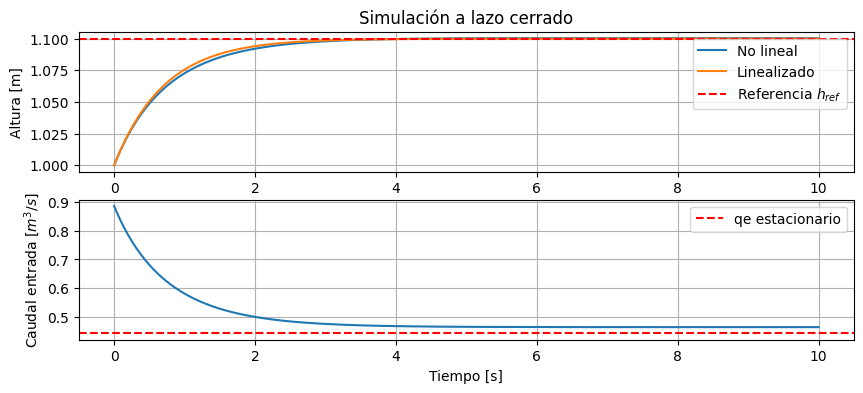

In [65]:
tau = 1/alpha_subs
K = beta_subs * tau

# Pido velocidad de respuesta
gamma = 0.05

Kp = 1/K/gamma
Ti = tau

# Cómo queda el modelo lineal controlado por el PID
s = ctrl.TransferFunction.s
C = Kp*(1 + 1/(Ti*s))
Gcl = ctrl.feedback(C*G,1)

def lc(t, x):
    h = x[0]
    z = x[1]

    e = h_ref-h

    q = float(qe0_val + Kp * (e + 1/Ti*z))
    if q<0:
        q=0
    elif q>q_max:
        q=q_max
    
    # dinámica del tanque
    dhdt = dhdt_lambda(q,h)
    dzdt = e

    return [dhdt,dzdt]

t_eval = np.linspace(t_span[0], t_span[1], 5000)
sol = solve_ivp(lc, t_span, [hini,0.0], t_eval=t_eval, method='RK45')

h_sol = sol.y[0]
z_sol = sol.y[1]
q_t = qe0_val + Kp * (h_ref - h_sol) + Kp/Ti * z_sol

# Y el lineal
t,y = ctrl.step_response(Gcl,T=t_eval)

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(sol.t, h_sol, label='No lineal')
plt.plot(t, y*(h_ref-hini)+hini, label='Linealizado')
plt.axhline(h_ref,color='r', linestyle='--', label='Referencia $h_{ref}$')
plt.ylabel('Altura [m]')
plt.title('Simulación a lazo cerrado')
plt.grid(True)
plt.legend()
plt.subplot(2,1,2)
plt.plot(sol.t,q_t)
plt.axhline(qe0_val,color='r', linestyle='--', label='qe estacionario')
plt.ylabel('Caudal entrada $[m^3/s]$')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid(True)

plt.show()

# ¿Cómo armar un controlador más general de tiempo continuo?

Puedo juntar las dinámicas del controlador y de la planta en un nuevo sistema en VE e integrar todo junto 

Controlador en TF



TransferFunction(array([62.83185307,  4.42944692]), array([14.18503353,  0.        ]))

Controlador en VE:



StateSpace(array([[-0.]]), array([[1.]]), array([[0.312262]]), array([[4.42944692]]))

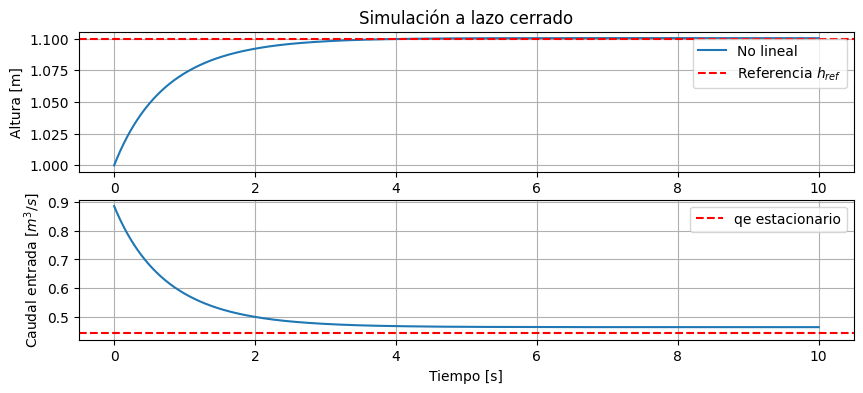

In [ ]:
#Td = Ti/100
#C = Kp*(1+1/(Ti*s)+s*Td/(Td/100*s+1))
C = Kp*(1+1/(Ti*s))
print("Controlador en TF\n")
display(C)

# Armo el controlador en VE para poder integrarlo en el modelo control + planta
Gss = ctrl.tf2ss(C)
print("Controlador en VE:\n")
display(Gss)

def lc_pid(t, x):
    h = x[0]    
    e = np.array(h_ref-h).reshape(-1,1)
    
    # Recupero los estados del controlador y armo el vector columna
    xc = np.array(x[1:]).reshape(-1,1)
    # Calculo la nueva acción de control como la salida del controlador en VE
    q = qe0_val + float(Gss.C @ xc + Gss.D @ e)
    # Planteo la evolución del estado del controlador
    dxc = Gss.A @ xc + Gss.B @ e    
    if q<0:
        q=0
    elif q>q_max:
        q=q_max
    
    # dinámica del tanque
    dhdt = dhdt_lambda(q,h)
    return [dhdt]+list(dxc.flatten())

t_eval = np.linspace(t_span[0], t_span[1], 5000)
sol = solve_ivp(lc_pid, t_span, [hini] + list(np.zeros(Gss.nstates)), t_eval=t_eval, method='RK45')

h_sol = sol.y[0]
# Calculo la accion de control a partir de la evolución de los estados del controlador
# Pero cuidado que acá no entra la saturación!
xc_sol = sol.y[1:]
e = np.reshape(h_ref-sol.y[0],(1,5000))
q_sol = (Gss.C @ xc_sol + Gss.D @ e).flatten() + qe0_val

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(sol.t, h_sol, label='No lineal')
#plt.plot(t, y*(h_ref-hini)+hini, label='Linealizado')
plt.axhline(h_ref,color='r', linestyle='--', label='Referencia $h_{ref}$')
plt.ylabel('Altura [m]')
plt.title('Simulación a lazo cerrado')
plt.grid(True)
plt.legend()
plt.subplot(2,1,2)
plt.plot(sol.t,q_sol)
plt.axhline(qe0_val,color='r', linestyle='--', label='qe estacionario')
plt.ylabel('Caudal entrada $[m^3/s]$')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid(True)

plt.show()
